In [1]:
# !pip uninstall tensorflow
# !pip install tensorflow-gpu==2.11.0

In [2]:
# Import necessary packages

import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
import gensim.downloader as api

import string
import nltk
nltk.download('punkt')
import re

import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
tf.__version__

'2.12.0'

### Part 1: Preprocessing Text

The first step is to import data and preprocess it.

The steps of preprocessing texts are as follows:
1. Change all words to lowercase
2. Cleaning punctuations and translating abbreviations
3. Tokeniza the words. Example: "Machine learning is fun" becomes ['machine', 'learning', 'is', 'fun']
4. Removing stop words. Words like 'the', 'a', etc often carry little to no meaning, so it's better to remove them before changing our list of words into numerical data.
5. Removing numbers

In [4]:
def preprocess_question(df, raw):

  # string cleaning function
  def clean_word(word):
    word = str(word)
    # lowercase
    word = word.lower()
    word = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", word)
    # cleaning operators
    word = re.sub(r"\/", " ", word)
    word = re.sub(r"\^", " ^ ", word)
    word = re.sub(r"\+", " + ", word)
    word = re.sub(r"\-", "", word)
    word = re.sub(r"\=", " = ", word)
    # translating abbreviations
    word = re.sub(r"\'re", 'are', word)
    word = re.sub(r"\'ve", 'have', word)
    word = re.sub(r"\'t", 'not', word)
    word = re.sub(r"\'d", 'would', word)
    word = re.sub(r"\'m", 'am', word)
    word = re.sub("where's", 'where is', word)
    word = re.sub("what's", 'what is', word)
    word = re.sub("how's", 'how is', word)
    word = re.sub("who's", 'who is', word)
    word = re.sub("why's", 'why is', word)
    word = re.sub("he's", 'he is', word)
    word = re.sub("it's", 'it is', word)
    word = re.sub("she's", 'she is', word)
    word = re.sub("\'s", 'possession', word)
    word = re.sub("eg", 'example', word)
    word = re.sub("usa", 'america', word)
    word = re.sub("u.s.a", 'america', word)
    word = re.sub("\'ll", 'will', word)
    word = re.sub("uk", 'england', word)
    word = re.sub("911", 'emergency', word)
    return word

  # removing punctuation function
  punct =[]
  punct += list(string.punctuation)
  punct += '’'
  punct.remove("'")

  def remove_punctuations(text):
      for punctuation in punct:
          text = text.replace(punctuation, ' ')
      return text

  df_input = df
  df_input['cleaned'] = df_input[raw].apply(clean_word)
  # getting rid of whitespaces
  df_input['cleaned'] = df_input[raw].apply(lambda x: str(x).replace('\n', ' '))
  # remove links
  df_input['cleaned'] = df_input['cleaned'].str.replace('http\S+|www.\S+', '', case=False)
  # removing '>'
  df_input['cleaned'] = df_input['cleaned'].apply(lambda x: x.replace('&gt;', ''))
  # removing '<'
  df_input['cleaned'] = df_input['cleaned'].apply(lambda x: x.replace('&lt;', ''))
  # remove punctuation
  df_input['cleaned'] = df_input['cleaned'].apply(remove_punctuations)
  # remove ' s ' that was created after removing punctuations
  df_input['cleaned'] = df_input['cleaned'].apply(lambda x: str(x).replace(" s ", " "))
  # apply tokenization
  df_input['tokenized'] = df_input['cleaned'].apply(word_tokenize)
  # remove stop words
  df_input['tokenized'] = df_input['tokenized'].apply(lambda word_list: [x for x in word_list if x not in ENGLISH_STOP_WORDS])
  # remove numbers
  df_input['tokenized'] = df_input['tokenized'].apply(lambda list_data: [x for x in list_data if x.isalpha()])

  # finalizing the preprocessing
  finale = list()
  for list_of_words in df_input.tokenized:
    finale.append(' '.join(list_of_words))

  df_input['final_text'] = finale

  return df_input.tokenized

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Load the data
quora = pd.read_csv('/content/drive/My Drive/quora_duplicate_questions.tsv', sep='\t')
questions_df = quora[['question1', 'question2', 'is_duplicate']]

y = questions_df['is_duplicate']
q1 = questions_df[['question1']]
q2 = questions_df[['question2']]

# preprocess question1
question1_word_tokenized = preprocess_question(q1, 'question1')
question2_word_tokenized = preprocess_question(q2, 'question2')

<ipython-input-4-1d2d81042046>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input['cleaned'] = df_input[raw].apply(clean_word)
<ipython-input-4-1d2d81042046>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input['cleaned'] = df_input[raw].apply(lambda x: str(x).replace('\n', ' '))
<ipython-input-4-1d2d81042046>:54: FutureWarning: The default value of regex will change from True to False in a future version.
  df_input['cleaned'] = df_input['cleaned'].str.replace('http\S+|www.\S+', '', case=Fals

In [7]:
question1_word_tokenized

0         [What, step, step, guide, invest, share, marke...
1               [What, story, Kohinoor, Koh, Noor, Diamond]
2         [How, I, increase, speed, internet, connection...
3                 [Why, I, mentally, lonely, How, I, solve]
4         [Which, dissolve, water, quikly, sugar, salt, ...
                                ...                        
404285    [How, keywords, Racket, programming, language,...
404286                           [Do, believe, life, death]
404287                                         [What, coin]
404288    [What, approx, annual, cost, living, studying,...
404289                            [What, like, sex, cousin]
Name: tokenized, Length: 404290, dtype: object

Next, we're making a dictionary containing each unique words in our dataset, and the corresponding number of each word.

Example:
- Question 1 : 'We are eating lunch'
- Question 2 : 'We are having lunch'

Dictionary:
- We : 1, are : 2, eating : 3, lunch : 4, having : 5

Outcome: 
- Question 1 : [1, 2, 3, 4]
- Question 2 : [1, 2, 5, 4]

Logic behind the next cell's algorithm is as follows.

- Let's take a look at our first question. The first word is 'We'. Our 'vocabulary' dictionary is empty at this moment. However, our ```inverse_vocabulary``` list already as a member, which is the '\<placeholder>'.

- Since 'we' is not yet in the dictionary, we will add the word 'we' as the first entry in the dictionary. 

- The word 'we' is the encoded to the number 1. This number is the length of the ```inverse_vocabulary``` list.

- After that, we add the word 'we' to the ```inverse_vocabulary``` list. 

- Fast forward to the first word in the second question. Because the word 'we' is already inside the the vocabulary, it just simply assigns the word 'we' to the number '1'.

We want to start our numbering at '1', that's why we have the '\<placeholder>' member of the ```inverse_vocabulary``` list.


In [8]:
q1_v = list()
q2_v = list()
vocabulary = dict()
inverse_vocabulary = ['<placeholder>']

for row in question1_word_tokenized:
  q1_number = []
  for word in row:
    if word not in vocabulary:
      vocabulary[word] = len(inverse_vocabulary)
      q1_number.append(len(inverse_vocabulary))
      inverse_vocabulary.append(word)
    else:
      q1_number.append(vocabulary[word])
  q1_v.append(q1_number)

for row in question2_word_tokenized:
  q2_number = []
  for word in row:
    if word not in vocabulary:
      vocabulary[word] = len(inverse_vocabulary)
      q2_number.append(len(inverse_vocabulary))
      inverse_vocabulary.append(word)
    else:
      q2_number.append(vocabulary[word])
  q2_v.append(q2_number)

Here's the resulting dataframe

In [9]:
x = pd.DataFrame(zip(q1_v,q2_v))
x = x.rename({0:'q1', 1:'q2'}, axis = 'columns')
x

,q1,q2
0,"[1, 2, 2, 3, 4, 5, 6, 7]","[1, 2, 2, 3, 4, 5, 6]"
1,"[1, 8, 9, 10, 11, 12]","[1, 750, 361, 157, 4563, 9, 10, 11, 9173]"
2,"[13, 14, 15, 16, 17, 18, 19, 20]","[13, 354, 16, 1699, 472, 46295]"
3,"[21, 14, 22, 23, 13, 14, 24]","[4907, 11467, 1286, 1286, 13475]"
4,"[25, 26, 27, 28, 29, 30, 31, 32, 33, 34]","[25, 3089, 5777, 30, 27]"
...,...,...
404285,"[13, 2512, 69394, 302, 1231, 1488, 2515]","[13, 2512, 94305, 305, 306, 1488, 2515]"
404286,"[722, 1608, 356, 1175]","[201, 1425, 356, 1175]"
404287,"[1, 8826]","[1, 8826]"
404288,"[1, 18110, 12357, 315, 2159, 2400, 49897, 6918...","[14, 2115, 4055, 1922, 1748, 14, 95, 50, 587, ..."


### Part 2 : Preparing Embedding Layer and Model

In this part, we're going to download a Glove pretrained embedding layer, which will convert our words into n-dimensions vector. Since the version that we download is called 'gigaword-300', the resulting numerical vectors will be 300 dimensions.

In [10]:
model = api.load("glove-wiki-gigaword-300")
embedding_dim = 300

[==================================================] 100.0% 376.1/376.1MB downloaded


In [11]:
# create an embedding matrix using numpy array
# generate random numbers for words that might be in our vocab dict but not in 
# the glove's vocabulary

embeddings = 1 * np.random.randn(len(vocabulary) + 1, 300)  
embeddings[0] = 0 

for word, index in vocabulary.items():
    if word in model.key_to_index: #.vocab
        embeddings[index] = model.word_vec(word)

<ipython-input-11-3228bff7edb6>:10: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  embeddings[index] = model.word_vec(word)


Here's a preview of what the embedding matrix looks like for the word 'machine'.

In [12]:
embeddings[vocabulary['machine']]

array([-0.20598   ,  0.84198999,  0.32655001, -0.55080003, -0.71978003,
        0.4463    ,  0.65963   , -0.083757  ,  0.31733   , -1.69280005,
        0.18900999, -0.56237   ,  0.60960001, -0.10732   ,  0.36826   ,
       -0.053698  ,  0.041387  , -0.28029001, -0.43241999,  0.36917001,
        0.56726003,  0.39636999,  0.15227   , -0.11159   ,  0.20497   ,
        0.25431001,  0.57173997, -0.24691001,  0.26312   , -0.076046  ,
       -0.26778999,  0.048289  ,  0.31213   ,  0.51489002, -0.13457   ,
        0.53894001,  0.15186   , -0.21444   , -0.2392    ,  0.29854   ,
       -0.073615  ,  0.44198   , -0.13692001, -0.22565   ,  0.46039   ,
        0.1428    ,  0.70315999, -0.23107   ,  0.63721001,  0.17203   ,
        0.21066999,  0.32497001, -0.02218   ,  0.5431    , -0.88348001,
       -0.53834999, -0.044051  , -0.12977999,  0.31841999,  0.31617999,
        0.22351   ,  0.021186  , -0.05058   ,  0.0056521 , -0.021808  ,
        0.61592001, -0.71762002,  0.20032001,  0.2207    ,  0.32

Now, let's prepare our dataset into training and testing set. We also do zero padding to ensure our input lengths are of the same shape.

In [13]:
# finding out maximum length of question
max_length = max(x.q1.map(lambda x : len(x)).max(),
                 x.q2.map(lambda x : len(x)).max())

# splitting data to train test split
test_size = 40000
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size)

# creating q1 and q2 partition
x_train = {'q1': x_train.q1, 'q2':x_train.q2}
x_test = {'q1':x_test.q1, 'q2':x_test.q2}

# convert y to numpy array
y_train = y_train.values
y_test = y_test.values

# zero padding
for data, part in itertools.product([x_train, x_test], ['q1', 'q2']):
  data[part] = tf.keras.preprocessing.sequence.pad_sequences(data[part], maxlen=max_length)

assert x_train['q1'].shape == x_train['q2'].shape

if len(x_train['q1']) == len(y_train):
  print('Data preparation complete. We can begin training now.')
else:
  print('Train data and label has different length.')

Data preparation complete. We can begin training now.


Now let's create a siamese network. Why is it called siamese? Because it has two inputs, in which both inputs are processed through the same layers before joined together in a 'merging' layer. This merging's layer output is then run through a few more layers, before the model outputs a '0' or '1' through a final Dense layer. 

Our merging layer here is a ```tf.keras.layers.Dot``` layer, which takes the dot product of two vectors. We set the 'normalize' argument to 'True', so it normalizes the dot product, and gives us the cosine similarity of both vectors.

The cosine similarity is then run through a few more batch normalization, dense, and dropout layers, before the final sigmoid-activated dense layer.

In [14]:
import tensorflow.keras.backend as k

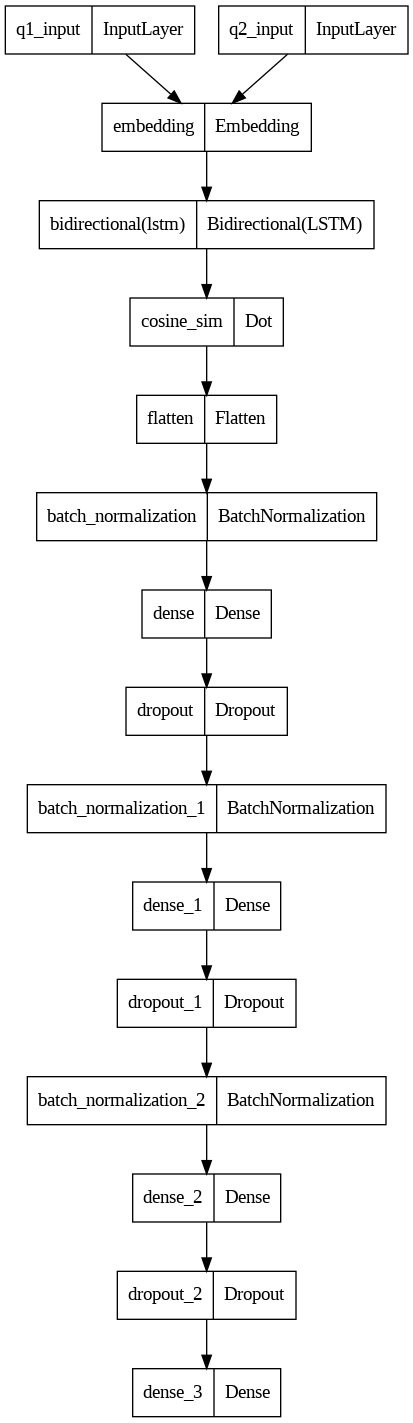

In [15]:
# Model variables
k.clear_session()
batch_size = 64

q1_input = tf.keras.layers.Input(shape = (max_length, ), dtype = 'int32', name = 'q1_input')
q2_input = tf.keras.layers.Input(shape = (max_length, ), dtype = 'int32', name = 'q2_input')

embedding_layer = tf.keras.layers.Embedding(len(embeddings), embedding_dim, 
                                            weights = [embeddings], 
                                            input_length = max_length,
                                            trainable = False)

q1_embed = embedding_layer(q1_input)
q2_embed = embedding_layer(q2_input)

lstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences = True))

q1_lstm = lstm_layer(q1_embed)
q2_lstm = lstm_layer(q2_embed)

dot_layer = tf.keras.layers.dot([q1_lstm,q2_lstm], [1,1], normalize = True, name = 'cosine_sim')
flatten_layer = tf.keras.layers.Flatten()(dot_layer)

bn_layer_1 = tf.keras.layers.BatchNormalization()(flatten_layer)
dn_layer_1 = tf.keras.layers.Dense(256, activation = 'selu')(bn_layer_1)
do_layer_1 = tf.keras.layers.Dropout(0.3)(dn_layer_1)

bn_layer_2 = tf.keras.layers.BatchNormalization()(do_layer_1)
dn_layer_2 = tf.keras.layers.Dense(256, activation = 'selu')(bn_layer_2)
do_layer_2 = tf.keras.layers.Dropout(0.3)(dn_layer_2)

bn_layer_3 = tf.keras.layers.BatchNormalization()(do_layer_2)
dn_layer_3 = tf.keras.layers.Dense(256, activation = 'selu')(bn_layer_3)
do_layer_3 = tf.keras.layers.Dropout(0.3)(dn_layer_3)

dense_predict = tf.keras.layers.Dense(1, activation = 'sigmoid')(do_layer_3)
full_model = tf.keras.models.Model([q1_input, q2_input], dense_predict)
full_model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = 'adam', metrics = ['accuracy'])

# tf.keras.utils.plot_model(full_model, show_shapes=True, show_layer_names=True)
tf.keras.utils.plot_model(full_model)

### Part 3 :  Training the Model

The model is then trained for 5 epochs.

In [16]:
history = full_model.fit([x_train['q1'], x_train['q2']], y_train, 
                         batch_size=batch_size, epochs=5,
                         validation_data=([x_test['q1'], x_test['q2']], y_test))

Epoch 1/5
5693/5693 [==============================] - 518s 89ms/step - loss: 0.4980 - accuracy: 0.7523 - val_loss: 0.4943 - val_accuracy: 0.7478
Epoch 2/5
5693/5693 [==============================] - 514s 90ms/step - loss: 0.4183 - accuracy: 0.8014 - val_loss: 0.4236 - val_accuracy: 0.8033
Epoch 3/5
5693/5693 [==============================] - 515s 90ms/step - loss: 0.3646 - accuracy: 0.8321 - val_loss: 0.4390 - val_accuracy: 0.7857
Epoch 4/5
5693/5693 [==============================] - 518s 91ms/step - loss: 0.3079 - accuracy: 0.8620 - val_loss: 0.4274 - val_accuracy: 0.8243
Epoch 5/5
5693/5693 [==============================] - 515s 90ms/step - loss: 0.2532 - accuracy: 0.8898 - val_loss: 0.4172 - val_accuracy: 0.8236


In [17]:
# function to plot model's loss
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

def plot_acc(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  plt.figure(figsize=(5,5))
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])


def plot_loss(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.figure(figsize=(5,5))
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

def plot_history(history):
  plot_acc(history)
  plot_loss(history)

<ipython-input-17-1dcf3c7a5c35>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


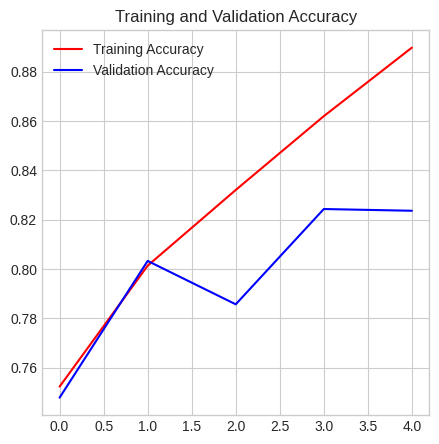

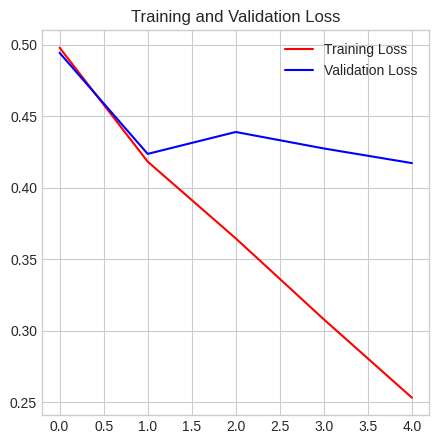

In [18]:
plot_history(history)

### Part 4 : Trying out our model

Let's try out our model using two pairs of questions. The first pair has similar meaning, while the second pair has a different meaning. 

In [19]:
new_text = "How to get familiar with machine learning?"
same_text = "What should I do to learn machine learning?"
dif_text = "Should machine learning be taught in kindergarten?"

In [20]:
dfnew = pd.DataFrame(np.array([[new_text, same_text], [new_text, dif_text]]),
                   columns=['text1', 'text2'])
dfnew1 = dfnew[['text1']]
dfnew2 = dfnew[['text2']]
text1_preprocess = preprocess_question(dfnew1, 'text1')
text2_preprocess = preprocess_question(dfnew2, 'text2')

t1v = list()
t2v = list()

for row_text1 in text1_preprocess:
  t1_num = []
  for word in row_text1:
    t1_num.append(vocabulary[word])
  t1v.append(t1_num)

for row_text2 in text2_preprocess:
  t2_num = []
  for word in row_text2:
    t2_num.append(vocabulary[word])
  t2v.append(t2_num)

x_new = pd.DataFrame(zip(t1v,t2v))
x_new = x_new.rename({0:'t1', 1:'t2'}, axis = 'columns')
x_input = {'q1': x_new.t1, 'q2':x_new.t2}

for data, part in itertools.product([x_input], ['q1', 'q2']):
  data[part] = tf.keras.preprocessing.sequence.pad_sequences(data[part], maxlen=max_length)

<ipython-input-4-1d2d81042046>:54: FutureWarning: The default value of regex will change from True to False in a future version.
  df_input['cleaned'] = df_input['cleaned'].str.replace('http\S+|www.\S+', '', case=False)
<ipython-input-4-1d2d81042046>:54: FutureWarning: The default value of regex will change from True to False in a future version.
  df_input['cleaned'] = df_input['cleaned'].str.replace('http\S+|www.\S+', '', case=False)


In [21]:
full_model.predict([x_input['q1'], x_input['q2']])

1/1 [==============================] - 2s 2s/step


array([[0.8253102 ],
       [0.00639854]], dtype=float32)

As we can see, the first pair of question has a similarity score of 0.82, while the second pair of question has a similarity score of 0.006. 

In [22]:
new_text = "How can I learn Spanish quickly?"
same_text = "What should I do to learn Spanish quickly?"
dif_text = "Should Spanish be taught in Spain?"
question1 = "What are the benefits of regular exercise?"
question2 = "How does engaging in physical activity positively impact our health?"

dfnew = pd.DataFrame(np.array([[new_text, same_text], [new_text, dif_text], [question1, question2]]),
                   columns=['text1', 'text2'])
dfnew1 = dfnew[['text1']]
dfnew2 = dfnew[['text2']]
text1_preprocess = preprocess_question(dfnew1, 'text1')
text2_preprocess = preprocess_question(dfnew2, 'text2')

t1v = list()
t2v = list()

for row_text1 in text1_preprocess:
  t1_num = []
  for word in row_text1:
    t1_num.append(vocabulary[word])
  t1v.append(t1_num)

for row_text2 in text2_preprocess:
  t2_num = []
  for word in row_text2:
    t2_num.append(vocabulary[word])
  t2v.append(t2_num)

x_new = pd.DataFrame(zip(t1v,t2v))
x_new = x_new.rename({0:'t1', 1:'t2'}, axis = 'columns')
x_new
x_input = {'q1': x_new.t1, 'q2':x_new.t2}

for data, part in itertools.product([x_input], ['q1', 'q2']):
  data[part] = tf.keras.preprocessing.sequence.pad_sequences(data[part], maxlen=max_length)

full_model.predict([x_input['q1'], x_input['q2']])

1/1 [==============================] - 0s 37ms/step


<ipython-input-4-1d2d81042046>:54: FutureWarning: The default value of regex will change from True to False in a future version.
  df_input['cleaned'] = df_input['cleaned'].str.replace('http\S+|www.\S+', '', case=False)
<ipython-input-4-1d2d81042046>:54: FutureWarning: The default value of regex will change from True to False in a future version.
  df_input['cleaned'] = df_input['cleaned'].str.replace('http\S+|www.\S+', '', case=False)


array([[0.94137305],
       [0.05798323],
       [0.14151819]], dtype=float32)